In [1]:
from reweight_functions import *
import pickle

### SETTING THE DIRECTORIES TO THE EXPERIMENTAL, COMPUTED DATA AND MAKING DIRECTORIES FOR THE OUTPUT AND FOR SAVING THE REWEIGHTED RMSES AS DICTIONARIES IN THEIR OWN DIRECTORIES

In [2]:
main_path = '/Users/kaushikborthakur1211/Desktop/Berlin_collab/'

outdir = os.path.join(main_path, 'reweight')
datadir = os.path.join(main_path, 'predicted_data')
expdatadir = os.path.join(main_path, 'Exp_Data')
weights_dir = os.path.join(outdir, 'weights')

if not os.path.exists(outdir):
    os.makedirs(outdir)
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)

single_dir = os.path.join(weights_dir + "/single_data")
if not os.path.exists(single_dir):
    os.makedirs(single_dir)

combined_dir = os.path.join(weights_dir + "/combined_data")
if not os.path.exists(combined_dir):
    os.makedirs(combined_dir)

dic_dir = os.path.join(outdir, 'dictionaries')
if not os.path.exists(dic_dir):
    os.makedirs(dic_dir)


### SETTING THE REWEIGHTING KEYS (DATA TYPES TO USE IN THE REWEIGHTING PROCEDURE)

In [3]:
chemical_shifts = ['CB', 'HA', 'CA', 'H', 'N', 'C']

colors = {'C': 'royalblue', 'HA': 'orange', 'CA': 'red', 'CB': 'forestgreen', 'H': 'mediumorchid',
            'N': 'darkslateblue', 'JHNHA': 'cornflowerblue', 'Rg': 'grey', 'RDC': 'firebrick', 'SAXS': 'teal',
            'Tot': 'black'}

theta_0 = {'HA': 1., 'CA': 1, 'CB': 1., 'C': 1., 'H': 1., 'HA2': 1., 'HA3': 1., 'N': 1., 'RDC': 1., 'Rg': 1.,
            'JHNHA': 1., 'SAXS': 1.}

to_remove = ['HA2', 'HA3']
reweighting_keys = ['CA', 'CB', 'HA', 'H', 'N', 'C','SAXS']


print('Main settings:\n')
print('Reweighting keys: {}'.format(reweighting_keys))


Main settings:

Reweighting keys: ['CA', 'CB', 'HA', 'H', 'N', 'C', 'SAXS']


### LOADING THE EXPERIMENTAL AND COMPUTED DATA.

### Data Parsing Functions

These functions read files and organize the data into nested dictionary structures. 

#### Function: `read_cs_md(data)`/`read_exp_cs(data)`

- **Input:** A file path to a comma-separated values (CSV) file for chemical shifts/PREs/SAXS profiles.
- **Output:** A nested dictionary with keys (`'HA'`, `'CA'`, `'CB'`, etc.) corresponding to a data-type, where:
  - The first element of each line is used as an inner dictionary key which could be a residue number for shifts or scattering angle for SAXS etc.
  - The values are numpy arrays of floats corresponding to the time-series data from simulation or the ensemble average experimental data.

#### Function: `Align_Comp_Exp_Data`

- **Input:** The compdata and expdata dictionaries we generate from function above.

- **Output:** New updated dictionaries for both such that they have information for common residue numbers/scattering angles etc. This is useful when the experimental data you have has information missing for certain residues but the computed shifts from SPARTA+ has time-series data for every residue.

In [5]:
expdata = read_exp_cs(join(expdatadir, 'CS.exp.dat'))
compdata = read_cs_md(join(datadir, 'cs_assignment.csv'), )

# expdata = add_exp_data(join(expdatadir, 'RDC.exp.dat'), expdata, 'RDC')
# compdata = add_md_data(join(datadir, 'RDC.all.csv'), compdata, 'RDC')


expdata = add_exp_data(expdatadir + '/SAXS.exp.dat', expdata, 'SAXS')
compdata = add_md_data(datadir + '/SAXS.csv', compdata, 'SAXS')

# Remove the '# drho = 3.34 ; r0 = 1.68' entry from compdata['SAXS']
compdata['SAXS'].pop('# drho = 3.34 ; r0 = 1.68', None)

# Replace each key in compdata['SAXS'] with the corresponding key from expdata['SAXS']
new_compdata_saxs = {}
for exp_key, comp_key in zip(expdata['SAXS'].keys(), compdata['SAXS'].keys()):
    new_compdata_saxs[exp_key] = compdata['SAXS'][comp_key]

# Replace the original compdata['SAXS'] with the new dictionary
compdata['SAXS'] = new_compdata_saxs


# Elimination of compdata that are not in expdata and viceversa
compdata, expdata = Align_Comp_Exp_Data(compdata, expdata)


nframes = len(compdata[list(compdata.keys())[1]][list(compdata[list(compdata.keys())[1]].keys())[0]])

# labels
exp_labels = list(compdata.keys())
true_exp_labels = [key for key in exp_labels if key not in to_remove]

print(
    'Correctely acquired data from experiments and for MD simulations for the following quantities:\n{}\nNumber of frames = {}'.format(
        [str(key) for key in compdata.keys()], nframes))

Correctely acquired data from experiments and for MD simulations for the following quantities:
['HA', 'CA', 'CB', 'C', 'H', 'HA2', 'HA3', 'N', 'SAXS']
Number of frames = 2999


### Reweighting and Validation Procedure

This code block initializes the reweighting process by putting the reweighting keys information in dictionaries.

#### Initialization
- `sd`: Dictionary to store standard deviations.
- `To_Scan`: List of keys to process for reweighting.

#### Separation of Data
- **Separate Reweight and Validation Data:**
 This function separates the input `CS` items and `true_exp_labels` into two distinct sets: `Reweight_Data` and `Validation_Data`.
 - **Inputs:**
  - `CS`: Can be a single key or list of keys.
  - `true_exp_labels`: A list of labels for the data-types used.

- **Outputs:**
  - `CS`: A string representation of the `CS` keys.
  - `Reweight_Data`: A list of keys (data-types) that need reweighting.
  - `Validation_Data`: A list of validation items, which are the remaining items in `true_exp_labels` after removing `CS` items.

#### Function: `Process_Data_Into_Arrays(data, expdata, compdata, err_d, compare_dict)`

- **Inputs:**
  - `data`: List of keys representing either Reweight_Data or Validation_Data.
  - `expdata`: Dictionary of experimental data.
  - `compdata`: Dictionary of computed MD timeseries data.
  - `err_d`: Dictionary of regularization parameter values which are all initialized at 1.0 for each data-type.
  - `compare_dict`: Dictionary to store comparison data.

- **Outputs:**
  - `exp`: Numpy array of experimental values.
  - `traj`: Numpy array of MD timeseries data.
  - `data_t`: List of data types (keys) (either r for reweight or v for validation).
  - `data_type`: Dictionary mapping keys to boolean arrays indicating the presence of data.
  - `compare_dict`: Updated comparison dictionary.


In [6]:
sd = {}
To_Scan = reweighting_keys
for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
    print('Reweight Data = {}'.format(CS))
    print('Validation Data = {}'.format(Validation_Data))

    ### debugging variables
    compare = []
    compare_dict_r = {key: {} for key in compdata.keys()}
    compare_dict_v = {key: {} for key in compdata.keys()}

    ####### B) The reweighting procedure

    # i) Process Reweight data into arrays 
    obs_exp_r, traj_r, err_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays(Reweight_Data,
                                                                                                expdata, compdata,
                                                                                                theta_0,
                                                                                                compare_dict_r)

    # ii) Process Validation data into arrays 
    obs_exp_v, traj_v, err_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays(Validation_Data,
                                                                                                expdata, compdata,
                                                                                                theta_0,
                                                                                                compare_dict_v)

    # final_weights

    for key in data_v_type:
        print(key)
        res = []
        md_ave = []
        sigmas = []
        exp = []
        sd[key] = {}
        for key2 in compare_dict_v[key]:
            timeseries = compare_dict_v[key][key2][1]
            uniform_weights = np.ones(len(timeseries))
            dim = 5000
            A, W = Weighted_Independent_Blocks(timeseries, uniform_weights, dim, verbose=False)
            ave = np.average(A, weights=W)
            sigma = Weighted_Sigma_of_Mean(A, W)
            sd[key][key2] = np.array([float(key2), float(compare_dict_v[key][key2][0]), float(ave), float(sigma)])

    for key in data_r_type:
        print(key)
        res = []
        md_ave = []
        sigmas = []
        exp = []
        sd[key] = {}
        for key2 in compare_dict_r[key]:
            timeseries = compare_dict_r[key][key2][1]
            uniform_weights = np.ones(len(timeseries))
            dim = 5000
            A, W = Weighted_Independent_Blocks(timeseries, uniform_weights, dim, verbose=False)
            ave = np.average(A, weights=W)
            sigma = Weighted_Sigma_of_Mean(A, W)
            sd[key][key2] = np.array([float(key2), float(compare_dict_r[key][key2][0]), float(ave), float(sigma)])

Reweight Data = CA
Validation Data = ['HA', 'CB', 'C', 'H', 'N', 'SAXS']
HA
CB
C
H
N
SAXS
CA
Reweight Data = CB
Validation Data = ['HA', 'CA', 'C', 'H', 'N', 'SAXS']
HA
CA
C
H
N
SAXS
CB
Reweight Data = HA
Validation Data = ['CA', 'CB', 'C', 'H', 'N', 'SAXS']
CA
CB
C
H
N
SAXS
HA
Reweight Data = H
Validation Data = ['HA', 'CA', 'CB', 'C', 'N', 'SAXS']
HA
CA
CB
C
N
SAXS
H
Reweight Data = N
Validation Data = ['HA', 'CA', 'CB', 'C', 'H', 'SAXS']
HA
CA
CB
C
H
SAXS
N
Reweight Data = C
Validation Data = ['HA', 'CA', 'CB', 'H', 'N', 'SAXS']
HA
CA
CB
H
N
SAXS
C
Reweight Data = SAXS
Validation Data = ['HA', 'CA', 'CB', 'C', 'H', 'N']
HA
CA
CB
C
H
N
SAXS


### INITIAL ROUND OF REWEIGHTING FOR A RANGE OF SIGMA_REG VALUES FOR EACH INDIVIDUAL DATA TYPE

### Reweighting Procedure with range of Regularization Parameters for one data-type at a time

This code performs a reweighting procedure over a range of regularization parameters (`thetas`) to evaluate the impact on root mean square error (RMSE) and Kish effective size.

#### Initialization
- **Variables:**
  - `To_Scan`: List of keys for reweighting.
  - `thetas`: Array of regularization parameters.
  - `ref_theta`: Reference value from `thetas`.
  - `RMSE_dict`: Dictionary to store RMSE values.
  - `KishScan_one_data`: Dictionary to store Kish effective size data.

#### Separation of Data
For each key in `To_Scan`:
- **Separate Reweight and Validation Data:**
- **Process_Data_Into_Arrays_with_sigma:** (store the information in dictionaries and calculate $/sigma_{MD}$ with block analysis)
- **Perform reweighting process per regularization value per data-type and minimize using L-BFGS algorithm**

For each data-type and iteration:

- **RMSEs and Kish values are calculated:**
  - **Kish Effective Size** (`Kish_ratio`): Measures the effective sample size after reweighting.
  - **RMSE (Root Mean Square Error):**
    - `RMSE_r_i`: Initial RMSE for Reweight Data.
    - `RMSE_r_f`: Final RMSE for Reweight Data.
    - `RMSE_v_i`: Initial RMSE for Validation Data.
    - `RMSE_v_f`: Final RMSE for Validation Data.

- **Results are stored in dictionaries:**
  - `RMSE_dict[CS][s]`: Stores Kish effective size and RMSE values for each regularization parameter (`theta_m`).
  - `KishScan_one_data[CS]`: Stores the list of `theta` values and their corresponding Kish effective sizes and final RMSE values for further analysis.




### Applying our Reweighting Theory Here

```python
def func_sigma_reg_sigma_md(l, traj_r, obs_exp_r, weight_bias, sigma_reg, sigma_md):
    l = np.array(l)  
    weight_all = +weight_bias  
    weight_all -= np.dot(l, traj_r)  
    shift_all = np.max(weight_all)  
    weight_all = np.exp(weight_all - shift_all)  
    weight_0 = +weight_bias  
    shift_0 = np.max(weight_0)  
    weight_0 = np.exp(weight_0 - shift_0)  

    # Gamma/Lagrange function in maxent:
    # Shifts to avoid overflows
    f = np.log(np.sum(weight_all) / np.sum(weight_0)) + shift_all - shift_0 + np.dot(l, obs_exp_r)

    # Derivative of Gamma function:
    der = obs_exp_r - np.dot(traj_r, weight_all) / np.sum(weight_all)  # Derivative with respect to l

    f += 0.5 * np.sum((sigma_reg * sigma_reg) * l ** 2 + sigma_md * sigma_md * l ** 2)
    der += sigma_reg * sigma_reg * l + sigma_md * sigma_md * l
    return f, der




Gamma function in the code refers to the following:
$$
 \mathcal{L} = D_{KL}[P_1|P_0]  - \sum_{i=1}^M \lambda_i \left [ \int P_1(x) f_i(x) dx - f_i^{\text{exp}} \right ] - \mu \left [ \int P_1 (x) dx - 1 \right ] 
$$
Derivative of the function is the following:
$$
\frac{\delta \mathcal{L}}{\delta P_1} = -\ln \frac{P_1}{P_0} - 1 - \sum_{i=1}^{M} \lambda_i f_i(\mathbf{x}) - \mu
$$
 The $\sigma$ values for reweighting is given by:
$$
\sigma_{i} = \sqrt{\sigma_{i,\text{MD}}^2 + \sigma_{\text{reg}}^2}
$$






In [7]:
To_Scan = reweighting_keys
thetas = np.linspace(0.001, 20, 200)
ref_theta = thetas[-1]
RMSE_dict = {}
KishScan_one_data = {}


for CS in To_Scan:
        CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
        KishScan_one_data[CS] = {}
        print('Reweight Data = {}'.format(CS))
        RMSE_dict[CS] = {}

        ### debugging variables
        compare = []
        compare_dict_r = {key: {} for key in compdata.keys()}
        compare_dict_v = {key: {} for key in compdata.keys()}

        ####### B) The reweighting procedure

        obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(
            Reweight_Data, expdata, compdata, theta_0, sd, compare_dict_r)
        obs_exp_v, traj_v, err_v, sigma_md_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays_with_sigma(
            Validation_Data, expdata, compdata, theta_0, sd, compare_dict_v)

        # THETA CYCLE
        theta_list = []
        kish_list = []
        rmsd_f_list = []
        for theta_m in np.flip(thetas):

            s = '{:.2f}'.format(theta_m)
            # print(s)
            sigma_reg = theta_m * err_r
            sigma_md = sigma_md_r
            RMSE_dict[CS][s] = {}

            # iv) Print dimensions
            nobs_r = len(obs_exp_r)
            nobs_v = len(obs_exp_v)
            # Print_Number_of_Data(nframes, nobs_r, nobs_v, data_r_type, data_v_type)

            # v) perform minimization
            # OBS: res.X = lagrange multiplier
            weight_bias = np.ones(nframes)

            if 'RDC' in Reweight_Data:
                initial_weights = weight_bias
                initial_weights /= np.sum(initial_weights)
                initial_obs_r = np.dot(traj_r, initial_weights)
                initial_obs_r
                exp_rdc = np.trim_zeros(obs_exp_r * data_r_type['RDC'])
                calc_rdc = np.trim_zeros(initial_obs_r * data_r_type['RDC'])
                qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
                qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

                if (qf_neg < qf_pos):
                    c = -c_neg
                else:
                    c = c_pos

                RDC_rows = np.where(data_r_type['RDC'] == 1)
                traj_r[RDC_rows] = traj_r[RDC_rows] * c

            if 'RDC' in Validation_Data:
                initial_weights = weight_bias
                initial_weights /= np.sum(initial_weights)
                initial_obs_v = np.dot(traj_v, initial_weights)
                exp_rdc = np.trim_zeros(obs_exp_v * data_v_type['RDC'])
                calc_rdc = np.trim_zeros(initial_obs_v * data_v_type['RDC'])
                qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
                qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

                if (qf_neg < qf_pos):
                    c = -c_neg
                else:
                    c = c_pos

                RDC_rows = np.where(data_v_type['RDC'] == 1)
                traj_v[RDC_rows] = traj_v[RDC_rows] * c

            res = sp.optimize.minimize(func_sigma_reg_sigma_md,
                                       args=(traj_r, obs_exp_r, weight_bias, sigma_reg, sigma_md),
                                       x0=np.zeros((nobs_r,)), method='L-BFGS-B', jac=True)
            initial_weights = Normalize_Weights(weight_bias)
            initial_obs_r = np.dot(traj_r, initial_weights)
            initial_obs_v = np.dot(traj_v, initial_weights)

            final_weights = Normalize_Weights(weight_bias - np.dot(res.x, traj_r))
            final_obs_r = np.dot(traj_r, final_weights)
            final_obs_v = np.dot(traj_v, final_weights)
            # g) calculating Kish effective size
            Ks_b = np.average(initial_weights) ** 2 / np.average(initial_weights ** 2)
            Ks_a = np.average(final_weights) ** 2 / np.average(final_weights ** 2)

            Kish_ratio = (Ks_a / Ks_b) * 100
            RMSE_initial = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))
            RMSE_reweight = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))

            theta_list.append(theta_m)
            kish_list.append(Kish_ratio)
            rmsd_f_list.append(RMSE_reweight)
            RMSE_r_i = {}
            RMSE_v_i = {}
            RMSE_r_f = {}
            RMSE_v_f = {}
            RMSE_r_i['Tot'] = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))

            for t in data_r_type:
                RMSE_r_i[t] = np.sqrt(
                    np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
                if str(t) == 'RDC':
                    qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                                       obs_exp_r * data_r_type['RDC'])
                    RMSE_r_i['RDC'] = qf

            RMSE_v_i['Tot'] = np.sqrt(
                np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
            for t in data_v_type:
                RMSE_v_i[t] = np.sqrt(
                    np.sum((initial_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t]))
                if str(t) == 'RDC':
                    qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_v * data_v_type['RDC'],
                                                                       obs_exp_v * data_v_type['RDC'])
                    RMSE_v_i['RDC'] = qf

            RMSE_r_f['Tot'] = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))

            for t in data_r_type:
                RMSE_r_f[t] = np.sqrt(np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
                if str(t) == 'RDC':
                    qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                       obs_exp_r * data_r_type['RDC'])
                    RMSE_r_f['RDC'] = qf

            for t in data_v_type:
                RMSE_v_f[t] = np.sqrt(np.sum((final_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t]))
                if str(t) == 'RDC':
                    qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(final_obs_v * data_v_type['RDC'],
                                                                       obs_exp_v * data_v_type['RDC'])
                    RMSE_v_f['RDC'] = qf

            RMSE_dict[CS][s]['Kish'] = Kish_ratio
            RMSE_dict[CS][s]['r_i'] = RMSE_r_i
            RMSE_dict[CS][s]['r_f'] = RMSE_r_f
            RMSE_dict[CS][s]['v_i'] = RMSE_v_i
            RMSE_dict[CS][s]['v_f'] = RMSE_v_f

        KishScan_one_data[CS]['kish'] = np.column_stack((theta_list, kish_list))
        KishScan_one_data[CS]['rmsd'] = np.column_stack((theta_list, rmsd_f_list))

Reweight Data = CA
Reweight Data = CB
Reweight Data = HA
Reweight Data = H
Reweight Data = N
Reweight Data = C
Reweight Data = SAXS


### Finding Optimal Regularization Parameter

This code iterates through `KishScan_one_data` to find a `theta_m` that meets a minimum Kish ratio (`kish_min`). It selects the last `theta_m` value above `kish_min` and, if zero, uses the second-to-last value.

#### Process:
- **Initialization:**
  - `kish_min = 10`: Minimum threshold for the Kish ratio.
  - `theta_dict`: Dictionary to store selected `theta_m` values for each `key` in `KishScan_one_data`.
  - `Kish_ratio_vals`: List to collect `theta_m` values meeting the `kish_min` criteria.

- **Iteration:**
  - For each `key` in `KishScan_one_data`:
    - Retrieve Kish ratios (`kish`) from `KishScan_one_data[key]['kish']`.
    - Identify indices (`b`) where Kish ratio meets or exceeds `kish_min`.
    - Select `theta_m` as the last valid value (so lowest value) from `kish` that meets the criteria.
    - If `theta_m` is zero, fallback to the second-to-last valid value (`k[idy][0]`).
    - Store `theta_m` in `theta_dict[key]`.

- **Output:**
  - `theta_dict`: Dictionary mapping each key to the selected `theta_m` that meets the `kish_min` criteria.


In [8]:
kish_min = 10
theta_dict = {}
Kish_ratio_vals = []
for key in KishScan_one_data:
    k = KishScan_one_data[key]['kish']
    b = (np.where(k[:, 1] >= kish_min))[0]
    idx = b[-1]
    idy = b[-2]
    theta_m = k[idy][0]
    Kish_ratio_vals.append(theta_m)
    # if (theta_m == 0):
    #     theta_m = k[idy][0]
    theta_dict[key] = {}
    theta_dict[key] = (theta_m)


In [9]:
def print_results():
    print(CS, "Theta:", theta_m, "Kish: %9.6lf" % (Kish_ratio), "RMSD initail: %0.4f" % RMSE_initial,
            "RMSD final: %0.4f" % RMSE_reweight)

    print("Initial RMSE reweight data ")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(
            np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))

        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                                obs_exp_r * data_r_type['RDC'])

            print(" *    RDC scaled Q:", end='')
            print(" %6.3lf" % qf)

    print("Initial RMSE validation data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_v - obs_exp_v) ** 2)))

    for t in data_v_type:
        print(" *    %2s :" % t, end='')
  
        print("     %6.3lf" % np.sqrt(
            np.sum((initial_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_v * data_v_type['RDC'],
                                                                obs_exp_v * data_v_type['RDC'])
 
            print(" *    RDC scaled Q:", end='')
            print(" %6.3lf" % qf)

    print("Final RMSE reweight data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(
            np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdcs_scale_f, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                obs_exp_r * data_r_type['RDC'])

            print(" *    RDC Q_scaled:", end='')
            print(" %6.3lf" % qf)

    print("Final RMSE validation data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_v - obs_exp_v) ** 2)))

    for t in data_v_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(
            np.sum((final_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_f, c = scale_rdc_Q(final_obs_v * data_v_type['RDC'],
                                                                obs_exp_v * data_v_type['RDC'])
           
            print(" *    RDC Q_scaled:", end='')
            print(" %6.3lf" % qf)


### Reweighting Individual Data-Types based on optimal regularization parameter as found above
- We found optimal regularization paramters as discussed above
- We run the same reweighting process on each data type for it's own optimal regularization parameter instead of iterating over a range of values

In [10]:
To_Scan = reweighting_keys

for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
    print('Reweight Data = {}'.format(CS))
    CS_dir = join(single_dir, CS)
    if not os.path.exists(CS_dir):
        os.makedirs(CS_dir)

    compare = []
    compare_dict_r = {key: {} for key in compdata.keys()}
    compare_dict_v = {key: {} for key in compdata.keys()}

    obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(
        Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)
    obs_exp_v, traj_v, err_v, sigma_md_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays_with_sigma(
        Validation_Data, expdata, compdata, theta_0, sd, compare_dict_v)

    theta_m = theta_dict[CS]
    s = '{:.2f}'.format(theta_m)
    print(s)
    sigma_reg = theta_m
    sigma_md = sigma_md_r
    
    # sigma_md = np.zeros(len(sigma_md_r))

    # iv) Print dimensions
    nobs_r = len(obs_exp_r)
    nobs_v = len(obs_exp_v)

    # v) perform minimization
    # OBS: res.X = lagrange multiplier
    weight_bias = np.ones(nframes)
    if 'RDC' in Reweight_Data:
        intial_weights = weight_bias
        initial_weights /= np.sum(initial_weights)
        initial_obs_r = np.dot(traj_r, initial_weights)
        initial_obs_r
        exp_rdc = np.trim_zeros(obs_exp_r * data_r_type['RDC'])
        calc_rdc = np.trim_zeros(initial_obs_r * data_r_type['RDC'])
        qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
        qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

        if (qf_neg < qf_pos):
            c = -c_neg
        else:
            c = c_pos
        RDC_rows = np.where(data_r_type['RDC'] == 1)
        traj_r[RDC_rows] = traj_r[RDC_rows] * c

    if 'RDC' in Validation_Data:
        intial_weights = weight_bias
        initial_weights /= np.sum(initial_weights)
        initial_obs_v = np.dot(traj_v, initial_weights)
        initial_obs_v
        exp_rdc = np.trim_zeros(obs_exp_v * data_v_type['RDC'])
        calc_rdc = np.trim_zeros(initial_obs_v * data_v_type['RDC'])
        qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
        qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

        if (qf_neg < qf_pos):
            c = -c_neg
        else:
            c = c_pos
        RDC_rows = np.where(data_v_type['RDC'] == 1)
        traj_v[RDC_rows] = traj_v[RDC_rows] * c

    res = sp.optimize.minimize(func_sigma_reg_sigma_md, args=(traj_r, obs_exp_r, weight_bias, sigma_reg, sigma_md),
                                x0=np.zeros((nobs_r,)), method='L-BFGS-B', jac=True)
    initial_weights = Normalize_Weights(weight_bias)
    initial_obs_r = np.dot(traj_r, initial_weights)
    initial_obs_v = np.dot(traj_v, initial_weights)
    final_weights = Normalize_Weights(weight_bias - np.dot(res.x, traj_r))
    # e) final average observables for reweighting and validation
    final_obs_r = np.dot(traj_r, final_weights)
    final_obs_v = np.dot(traj_v, final_weights)
    # g) calculating Kish effective size
    Ks_b = np.average(initial_weights) ** 2 / np.average(initial_weights ** 2)
    Ks_a = np.average(final_weights) ** 2 / np.average(final_weights ** 2)
    Kish_ratio = (Ks_a / Ks_b) * 100
    RMSE_initial = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))
    RMSE_reweight = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))
    print(np.average(sigma_md_r))
    print_results()

   
    np.savetxt('%s/weights_final.dat' % (CS_dir), final_weights, fmt=" %6.12lf")
    # print final weights to file

    f = open("%s/weights_final.a.dat" % CS_dir, "w")
    for w in final_weights:
        f.write("%e\n" % w)
    f.close()

Reweight Data = CA
5.33
0.0
CA Theta: 5.327366834170855 Kish: 12.503068 RMSD initail: 4.5405 RMSD final: 4.3293
Initial RMSE reweight data 
 * Total :      4.541
 *    CA :      4.541
Initial RMSE validation data
 * Total :      6.820
 *    HA :      0.276
 *    CB :     15.801
 *     C :      1.432
 *     H :      0.230
 *     N :      3.656
 *    SAXS :      0.878
Final RMSE reweight data
 * Total :      4.329
 *    CA :      4.329
Final RMSE validation data
 * Total :      6.833
 *    HA :      0.269
 *    CB :     15.804
 *     C :      1.436
 *     H :      0.241
 *     N :      3.797
 *    SAXS :      0.923
Reweight Data = CB
9.55
0.0
CB Theta: 9.548261306532662 Kish: 11.240763 RMSD initail: 15.8015 RMSD final: 15.6629
Initial RMSE reweight data 
 * Total :     15.801
 *    CB :     15.801
Initial RMSE validation data
 * Total :      2.474
 *    HA :      0.276
 *    CA :      4.541
 *     C :      1.432
 *     H :      0.230
 *     N :      3.656
 *    SAXS :      0.878
Final RM

### REWEIGHTING ON A RANGE OF PARAMETER VALUES AFTER COMBINING ALL DATA

#### Initialization
- We combine all the data-types as a single key to pass
- **Variables:**
  - `To_Scan`: List of keys for reweighting which is a string of combined data ('CA-CB-H-JHNHA-N-RDC-HA').
  - `thetas`: Array of regularization parameters.
  - `ref_theta`: Reference value from `thetas`.
  - `RMSE_dict`: Dictionary to store RMSE values.
  - `KishScan_combined`: Dictionary to store Kish effective size data.

#### Separation of Data
For each key in `To_Scan`:
- **Separate Reweight and Validation Data:**
- **Process_Data_Into_Arrays_with_sigma:** (store the information in dictionaries and calculate $/sigma_{MD}$ with block analysis)
- **Perform reweighting process per regularization value per data-type and minimize using L-BFGS algorithm**

For each data-type and iteration:

- **RMSEs and Kish values are calculated:**
  - **Kish Effective Size** (`Kish_ratio`): Measures the effective sample size after reweighting.
  - **RMSE (Root Mean Square Error):**
    - `RMSE_r_i`: Initial RMSE for Reweight Data.
    - `RMSE_r_f`: Final RMSE for Reweight Data.
    - `RMSE_v_i`: Initial RMSE for Validation Data.
    - `RMSE_v_f`: Final RMSE for Validation Data.

- **Results are stored in dictionaries:**
  - `RMSE_dict_combined[CS][s]`: Stores Kish effective size and RMSE values for each regularization parameter (`theta_m`).
  - `KishScan_combinedCS]`: Stores the list of `theta` values and their corresponding Kish effective sizes and final RMSE values for further analysis.

In [11]:
combined_reweighting_keys = [reweighting_keys]
print('Reweighting keys: {}'.format(combined_reweighting_keys))

To_Scan = combined_reweighting_keys
thetas = np.linspace(0.01, 10, 40)
ref_theta = thetas[-1]
RMSE_dict_combined = {}
KishScan_combined = {}
for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
    KishScan_combined[CS] = {}
    CS_dir = join(combined_dir, CS)
    if not os.path.exists(CS_dir):
        os.makedirs(CS_dir)
    print('Reweight Data = {}'.format(CS))
    RMSE_dict_combined[CS] = {}
    combined_key_string = CS

    ### debugging variables
    compare = []
    compare_dict_r = {key: {} for key in compdata.keys()}

    ####### B) The reweighting procedure

    obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(
        Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)
    # THETA CYCLE
    theta_list = []
    kish_list = []
    rmsd_f_list = []
    for theta_m in np.flip(thetas):

        s = '{:.2f}'.format(theta_m)
        print(s)
        sigma_reg = theta_m * err_r
        #sigma_md = sigma_md_r
        sigma_md = np.zeros(len(sigma_md_r))
        RMSE_dict_combined[CS][s] = {}

        # iv) Print dimensions
        nobs_r = len(obs_exp_r)
        nobs_v = len(obs_exp_v)
        # Print_Number_of_Data(nframes, nobs_r, nobs_v, data_r_type, data_v_type)

        # v) perform minimization
        # OBS: res.X = lagrange multiplier
        weight_bias = np.ones(nframes)
        if 'RDC' in Reweight_Data:
            initial_weights = weight_bias
            initial_weights /= np.sum(initial_weights)
            initial_obs_r = np.dot(traj_r, initial_weights)
            initial_obs_r
            exp_rdc = np.trim_zeros(obs_exp_r * data_r_type['RDC'])
            calc_rdc = np.trim_zeros(initial_obs_r * data_r_type['RDC'])
            qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
            qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

            if (qf_neg < qf_pos):
                c = -c_neg
            else:
                c = c_pos

            RDC_rows = np.where(data_r_type['RDC'] == 1)
            traj_r[RDC_rows] = traj_r[RDC_rows] * c

        res = sp.optimize.minimize(func_sigma_reg_sigma_md,
                                    args=(traj_r, obs_exp_r, weight_bias, sigma_reg, sigma_md),
                                    x0=np.zeros((nobs_r,)), method='L-BFGS-B', jac=True)
        initial_weights = Normalize_Weights(weight_bias)
        initial_obs_r = np.dot(traj_r, initial_weights)
        # if res.success: print("\nMinimization worked: {}\n".format(res.success))
        # else: raise ValueError('Minimization with {}, theta = {} as reweighting data did not worked!'.format(CS, s))
        final_weights = Normalize_Weights(weight_bias - np.dot(res.x, traj_r))
        # e) final average observables for reweighting and validation
        final_obs_r = np.dot(traj_r, final_weights)

        # g) calculating Kish effective size
        Ks_b = np.average(initial_weights) ** 2 / np.average(initial_weights ** 2)
        Ks_a = np.average(final_weights) ** 2 / np.average(final_weights ** 2)

        Kish_ratio = (Ks_a / Ks_b) * 100
        RMSE_initial = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))
        RMSE_reweight = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))
        # print(CS,"Theta:",theta_m,"Kish: %9.6lf" % (Kish_ratio),"RMSD initail: %0.4f"%RMSE_initial,"RMSD final: %0.4f"%RMSE_reweight)
        theta_list.append(theta_m)
        kish_list.append(Kish_ratio)
        rmsd_f_list.append(RMSE_reweight)
        RMSE_r_i = {}
        RMSE_r_f = {}
        RMSE_r_i['Tot'] = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))

        for t in data_r_type:
            RMSE_r_i[t] = np.sqrt(
                np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
            if str(t) == 'RDC':
                qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                                    obs_exp_r * data_r_type['RDC'])
                RMSE_r_i['RDC'] = qf

        RMSE_r_f['Tot'] = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))
        for t in data_r_type:
            RMSE_r_f[t] = np.sqrt(np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
            if str(t) == 'RDC':
                qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                    obs_exp_r * data_r_type['RDC'])
                RMSE_r_f['RDC'] = qf

        RMSE_dict_combined[CS][s]['Kish'] = Kish_ratio
        RMSE_dict_combined[CS][s]['r_i'] = RMSE_r_i
        RMSE_dict_combined[CS][s]['r_f'] = RMSE_r_f
    KishScan_combined[CS]['kish'] = np.column_stack((theta_list, kish_list))
    KishScan_combined[CS]['rmsd'] = np.column_stack((theta_list, rmsd_f_list))

Reweighting keys: [['CA', 'CB', 'HA', 'H', 'N', 'C', 'SAXS']]
Reweight Data = CA-CB-HA-H-N-C-SAXS
10.00
9.74
9.49
9.23
8.98


8.72
8.46
8.21
7.95
7.69
7.44
7.18
6.93
6.67
6.41
6.16
5.90
5.65
5.39
5.13
4.88
4.62
4.36
4.11
3.85
3.60
3.34
3.08
2.83
2.57
2.32
2.06
1.80
1.55
1.29
1.03
0.78
0.52
0.27
0.01


### Finding Optimal Regularization Parameter for Combined Data Reweighting

This code iterates through `KishScan_combined` to find a `theta_m` that meets a minimum Kish ratio (`kish_min`). It selects the last `theta_m` value above `kish_min` and, if zero, uses the second-to-last value.

#### Process:
- **Initialization:**
  - `kish_min = 10`: Minimum threshold for the Kish ratio.
  - `theta_dict`: Dictionary to store selected `theta_m` values for each `key` in `KishScan_combined`.
  - `Kish_ratio_vals`: List to collect `theta_m` values meeting the `kish_min` criteria.

- **Iteration:**
  - For each `key` in `KishScan_combined`:
    - Retrieve Kish ratios (`kish`) from `KishScan_combined[key]['kish']`.
    - Identify indices (`b`) where Kish ratio meets or exceeds `kish_min`.
    - Select `theta_m` as the last valid value (so lowest value) from `kish` that meets the criteria.
    - If `theta_m` is zero, fallback to the second-to-last valid value (`k[idy][0]`).
    - Store `theta_m` in `theta_dict_combined[key]`.

- **Output:**
  - `theta_dict_combined`: Dictionary mapping each key to the selected `theta_m` that meets the `kish_min` criteria.

In [12]:
kish_min = 10
theta_dict_combined = {}
Kish_ratio_vals = []
for key in KishScan_combined:
    k = KishScan_combined[key]['kish']
    b = (np.where(k[:, 1] >= kish_min))[0]
    idx = b[-1]
    idy = b[-2]
    theta_m = k[idx][0]
    Kish_ratio_vals.append(theta_m)
    if (theta_m == 0):
        theta_m = k[idy][0]
    theta_dict_combined[key] = {}
    theta_dict_combined[key] = (theta_m)
    print(key, theta_m)

CA-CB-HA-H-N-C-SAXS 1.8030769230769232


In [13]:
def print_comb_results():
    print(CS, "Theta:", theta_m, "Kish: %9.6lf" % (Kish_ratio), "RMSD initail: %0.4f" % RMSE_initial,
          "RMSD final: %0.4f" % RMSE_reweight)

    # Iniitial RMSE and Sigma
    print("Initial RMSE reweight data ")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print(
            "     %6.3lf" % np.sqrt(np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))

        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                               obs_exp_r * data_r_type['RDC'])
            # print(" *    RDC scaled RMSD:", end = '')
            # print(" %6.3lf" % rms_f)
            print(" *    RDC scaled Q:", end='')
            print(" %6.3lf" % qf)

    print("Final RMSE reweight data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdcs_scale_f, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                obs_exp_r * data_r_type['RDC'])
            # print(" *    RDC RMSE_scale:", end = '')
            # print(" %6.3lf" % rms_f)
            print(" *    RDC Q_scaled:", end='')
            print(" %6.3lf" % qf)

### FUNCTION TO PLOT THE FITTING DATA

In [14]:
from matplotlib.ticker import StrMethodFormatter

def plot_fitting_data(weights):
    for t in Reweight_Data:
        if t != 'Rg':
            print(t)
            resid = []
            exp = []
            calc = []
            for i, id in enumerate(compare_dict_r[t]):
                resid.append(float(id))
                exp.append(compare_dict_r[t][id][0])
            initial = np.trim_zeros(initial_obs_r * data_r_type[t])
            reweight = np.trim_zeros(final_obs_r * data_r_type[t])
            exp = np.trim_zeros(obs_exp_r * data_r_type[t])
            rmsd_i = (sum(np.square(initial - exp)) / len(exp)) ** 0.5
            rmsd_f = (sum(np.square(reweight - exp)) / len(exp)) ** 0.5
            print("RMSD_initial:%6.3lf" % rmsd_i, "RMSD_final:%6.3lf" % rmsd_f)
            # plt.clf()
            if t == 'RDC':
                qi_initial, rms_initial, qf_initial, rms_f_initial, rdc_scale_i_initial, c = scale_rdc_Q(exp, initial)
                qi_reweight, rms_i_reweight, qf_reweight, rms_f_reweight, rdc_scale_i_reweight, c = scale_rdc_Q(exp,
                                                                                                                reweight)
                print("RMSD initial scale:%6.3lf" % rms_f_initial, "RMSD final scale:%6.3lf" % rms_f_reweight)
                print("Q initial scale:%6.3lf" % qf_initial, "Q final scale:%6.3lf" % qf_reweight)
                plt.plot(np.asarray(resid), initial, color='red', label="Unbiased")
                plt.plot(np.asarray(resid), reweight, color='darkred', linestyle='dashed', label="Reweighted")
                plt.plot(np.asarray(resid), exp, color='black', label='Exp')
                plt.ylabel(r'$D_{N-HN}$(Hz)', size=18)
                plt.title('%s' % t, size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residues', size=18)
                plt.legend(loc='upper left', fontsize=12)
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t), bbox_inches='tight')
                plt.show()

            elif t == 'SAXS':
                # plt.clf()
                plt.plot(np.asarray(resid), initial, color='red', label="Unbiased")
                plt.plot(np.asarray(resid), reweight, color='darkred', linestyle='dashed', label="Reweighted")
                plt.plot(np.asarray(resid), exp, color='black', label='Exp')
                plt.ylabel('Peak Intensity', size=18)
                plt.title('%s' % t, size='20')
                plt.xticks(size='12')
                plt.yticks(size='12')
                plt.grid()
                plt.xlabel('Scattering angle (q)', size=18, labelpad=7)
                # plt.axis.XAxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
                plt.legend(bbox_to_anchor=(1, 1.0), loc='upper left', fontsize=12)
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t),bbox_inches='tight')
                plt.show()


            elif t == 'CA':
                #plt.clf()
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
                plt.title(r"C$\alpha$", size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residue', size=18)
                plt.legend(loc='upper left')
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t),bbox_inches='tight')
                plt.show()

            elif t == 'CB':
                #plt.clf()
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
                plt.title(r"C$\beta$", size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residue', size=18)
                plt.legend(loc='upper right')
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t),bbox_inches='tight')
                plt.show()

            elif t == 'HA':
                #plt.clf()
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
                plt.title(r"H$\alpha$", size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residue', size=18)
                plt.legend(loc='upper left')
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t),bbox_inches='tight')
                plt.show()

            elif t == "JHNHA":
                #plt.clf()
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$^3J_{calc}$- $^3J_{exp}$|', size=20)
                plt.title(r"$^3JHNH\alpha$", size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residue', size=18)
                plt.legend(loc='upper right')
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf'%(outdir,t),bbox_inches='tight')
                plt.show()



            else:
                #plt.clf()
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
                plt.title('%s' % t, size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residue', size=18)
                plt.legend(loc='upper right')
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t),bbox_inches='tight')
                plt.show()
        

### REWEIGHTING WITH ALL THE DATA AND PLOTTING THE FIT TO EXPERIMENT
- We found optimal $\sigma_{reg}$ values above
- We do a final reweighting process on the combined data with that optimal parameter value
- We plot the calc vs exp fits before and after reweighting using `plot_fitting_data` function
- We save the final weights and the plots into the output directory

CA
RMSD_initial: 4.541 RMSD_final: 4.503


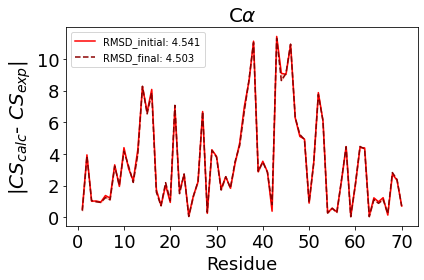

CB
RMSD_initial:15.801 RMSD_final:15.770


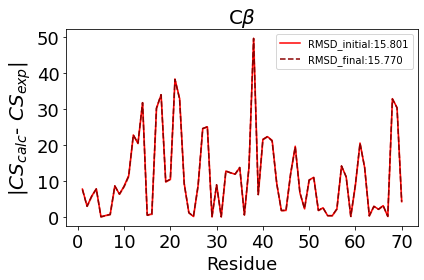

HA
RMSD_initial: 0.276 RMSD_final: 0.263


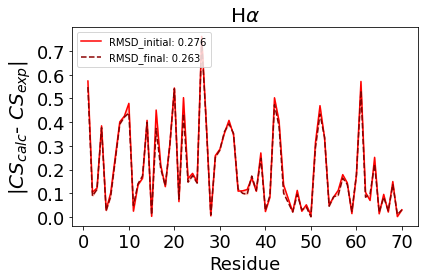

H
RMSD_initial: 0.230 RMSD_final: 0.209


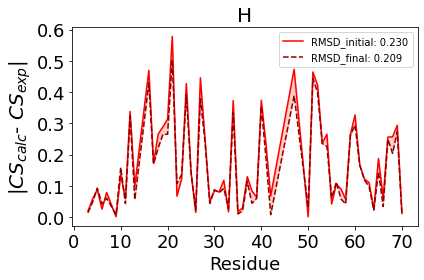

N
RMSD_initial: 3.656 RMSD_final: 3.527


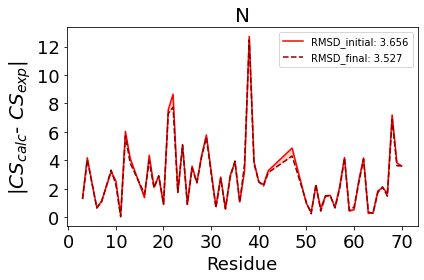

C
RMSD_initial: 1.432 RMSD_final: 1.396


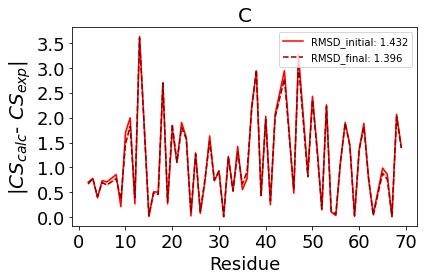

SAXS
RMSD_initial: 0.878 RMSD_final: 0.772


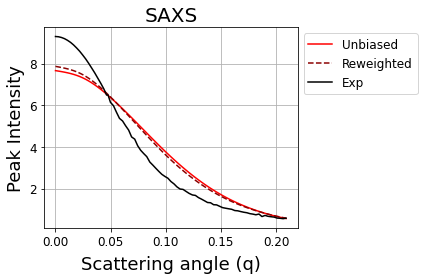

CA-CB-HA-H-N-C-SAXS Theta: 1.8030769230769232 Kish: 20.380258 RMSD initail: 6.5290 RMSD final: 6.5013
Initial RMSE reweight data 
 * Total :      6.529
 *    CA :      4.541
 *    CB :     15.801
 *    HA :      0.276
 *     H :      0.230
 *     N :      3.656
 *     C :      1.432
 *    SAXS :      0.878
Final RMSE reweight data
 * Total :      6.501
 *    CA :      4.503
 *    CB :     15.770
 *    HA :      0.263
 *     H :      0.209
 *     N :      3.527
 *     C :      1.396
 *    SAXS :      0.772


In [15]:
To_Scan=combined_reweighting_keys


CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(To_Scan[0], true_exp_labels)
obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)


s = '{:.2f}'.format(theta_m)

sigma_reg=theta_m*err_r
sigma_md=sigma_md_r


        

nobs_r = len(obs_exp_r)
nobs_v = len(obs_exp_v)
weight_bias=np.ones(nframes)
if 'RDC' in Reweight_Data:    
       initial_weights=weight_bias
       initial_weights/=np.sum(initial_weights)
       initial_obs_r=np.dot(traj_r,initial_weights)
       initial_obs_r
       exp_rdc=np.trim_zeros(obs_exp_r*data_r_type['RDC'])
       calc_rdc=np.trim_zeros(initial_obs_r*data_r_type['RDC'])
       qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos=scale_rdc_Q(exp_rdc,calc_rdc)
       #print(qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos)    
       qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg=scale_rdc_Q(-exp_rdc,calc_rdc)
       #print(qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg)

       if(qf_neg<qf_pos):
        c=-c_neg
       else: 
        c=c_pos
    
       RDC_rows=np.where(data_r_type['RDC']==1)
       traj_r[RDC_rows]=traj_r[RDC_rows]*c


res = sp.optimize.minimize(func_sigma_reg_sigma_md, args = (traj_r, obs_exp_r, weight_bias, sigma_reg,sigma_md), x0 =  np.zeros((nobs_r,)), method='L-BFGS-B',jac=True)
initial_weights = Normalize_Weights(weight_bias)
initial_obs_r=np.dot(traj_r,initial_weights)
final_weights = Normalize_Weights(weight_bias-np.dot(res.x,traj_r))
final_obs_r=np.dot(traj_r,final_weights)
Ks_b = np.average(initial_weights)**2/np.average(initial_weights**2)
Ks_a = np.average(final_weights)**2/np.average(final_weights**2)
        
Kish_ratio = (Ks_a/Ks_b)*100
RMSE_initial=np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2))
RMSE_reweight=np.sqrt(np.mean((final_obs_r-obs_exp_r)**2))

plot_fitting_data(final_weights)
print_comb_results()

np.savetxt('%s/weights_final.dat' % (CS_dir), final_weights, fmt=" %6.12lf")
# print final weights to file

f = open("%s/weights_final.a.dat" % CS_dir, "w")
for w in final_weights:
       f.write("%e\n" % w)
f.close()

In [16]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.5

### SAVING ALL THE INFORMATION FROM THE OPTIMIZED REWEIGHTING ROUNDS AS DICTIONARIES TO LOAD FOR MAKING THE ANALYSIS PLOTS

In [18]:
import pickle

with open('%s/RMSE_single.pkl' % dic_dir, 'wb') as fp:
    pickle.dump(RMSE_dict, fp)


with open('%s/RMSE_combined.pkl' % dic_dir, 'wb') as fp:
    pickle.dump(RMSE_dict_combined, fp)

with open('%s/theta_dict.pkl' % dic_dir, 'wb') as fp:
    pickle.dump(theta_dict, fp)

with open('%s/theta_dict_combined.pkl' % dic_dir, 'wb') as fp:
    pickle.dump(theta_dict_combined, fp)


with open('%s/KishScan_single_data.pkl' % dic_dir, 'wb') as fp:
    pickle.dump(KishScan_one_data, fp)

with open('%s/KishScan_combined.pkl' % dic_dir, 'wb') as fp:
    pickle.dump(KishScan_combined, fp)

with open('%s/colors.pkl' % dic_dir, 'wb') as fp:
    pickle.dump(colors, fp)

In [20]:
import mdtraj as md
import os
import sys
import numpy as np
import scipy as sp
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
import itertools
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq

In [21]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
sns.set_style("whitegrid")

In [22]:
def calc_SA(trj,helix,start,stop):
 RMS_start=start
 RMS_stop=stop
 RMS=[]
 for i in range(RMS_start,RMS_stop):
    sel=helix.topology.select("residue %s to %s and name CA" % (i,i+6))
    rmsd = md.rmsd(trj,helix,atom_indices=sel)
    RMS.append(rmsd)
 RMS=np.asarray(RMS)
 Sa_sum=np.zeros((trj.n_frames))
 Sa=(1.0-(RMS/0.08)**8)/(1-(RMS/0.08)**12)
 return Sa


def calc_Rg(trj):
 mass=[]
 for at in trj.topology.atoms:
    mass.append(at.element.mass)
 mass_CA = len(mass)*[0.0]
 for i in trj.topology.select("name CA"): mass_CA[i]=1.0
 rg_CA=md.compute_rg(trj, masses=np.array(mass_CA))
 return rg_CA

In [23]:
def free_energy(a,b,T,y0,ymax,x0,xmax):
  free_energy,xedges,yedges=np.histogram2d(a,b,30,[[y0,ymax],[x0,xmax]],normed=True,weights=None)
  free_energy=np.log(np.flipud(free_energy)+.000001)
  free_energy=-(0.001987*T)*free_energy
  return free_energy,xedges,yedges

def free_energy_reweight(a, b, T, y0, ymax, x0, xmax,weight):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=weight)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

In [24]:
def alphabeta_rmsd(phi,psi,phi_ref,psi_ref):
 alphabetarmsd=np.sum(0.5*(1+np.cos(psi-psi_ref)),axis=1)+np.sum(0.5*(1+np.cos(phi-phi_ref)),axis=1)
 return alphabetarmsd

In [25]:
def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1
 dsspH[dsspH=='E']=0
 dsspH[dsspH=='C']=0
 dsspH[dsspH=='NA']=0
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1)
 SE_H=np.zeros((len(dssp[0]),2))

 for i in range(0,len(dssp[0])):
     data=dsspH[:,i].astype(float)
     if(np.mean(data)>0):
      SE_H[i]=[np.mean(data),(block(data))**.5]

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1)
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE)
 SE_E=np.zeros((len(dssp[0]),2))

 for i in range(0,len(dssp[0])):
     data=dsspE[:,i].astype(float)
     if(np.mean(data)>0):
      SE_E[i]=[np.mean(data),(block(data))**.5]
 return SE_H, SE_E

In [26]:
def calc_phipsi(trj):
 indices_phi, phis = md.compute_phi(trj)
 indices_psi, psis = md.compute_psi(trj)
 phi_label=[]
 for i_phi in range(0, indices_phi.shape[0]):
      resindex=trj.topology.atom(indices_phi[i_phi][2]).residue.resSeq
      phi_label.append(resindex)
 phi_label=np.array(phi_label)
 #print(phi_label)
 psi_label=[]
 for i_psi in range(0, indices_psi.shape[0]):
      resindex=trj.topology.atom(indices_psi[i_psi][2]).residue.resSeq
      psi_label.append(resindex)
 psi_label=np.array(psi_label)
 #print(psi_label)
 phipsi=[]
 for i in range(0,len(phi_label)-1):
  current_phipsi=np.column_stack((phis[:,i+1],psis[:,i]))
  phipsi.append(current_phipsi)
 phipsi_array=np.array(phipsi)
 return(phipsi_array,psi_label,phi_label)

In [27]:
def block(x):
    d = log2(len(x))
    if (d - floor(d) != 0):
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    for i in arange(0,d):
        n = len(x)
        gamma[i] = (n)**(-1)*sum( (x[0:(n-1)]-mu)*(x[1:n]-mu) )
        s[i] = var(x)
        x = 0.5*(x[0::2] + x[1::2])

    M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]
    q =array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])
    for k in arange(0,d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")

    return (s[k]/2**(d-k))

In [28]:
pdb = '/Users/kaushikborthakur1211/Desktop/Berlin_collab/structure.pdb'
trajectory = '/Users/kaushikborthakur1211/Desktop/Berlin_collab/PaaA2_out.xtc'
helixpdb = '/Users/kaushikborthakur1211/Desktop/Paper_Repo/PaaA2/PaaA2.helix.pdb'
outdir = '/Users/kaushikborthakur1211/Desktop/Berlin_collab/ensembles'
weight_file = '/Users/kaushikborthakur1211/Desktop/Berlin_collab/reweight/weights/combined_data/CA-CB-HA-H-N-C-SAXS/weights_final.dat'
weights=np.loadtxt(weight_file)


if not os.path.exists(outdir):
    os.makedirs(outdir)


print("outdir",outdir)
print("pdb",pdb)
print("helixpdb",helixpdb)
print("trajectory",trajectory)
print("weights_file",weight_file)


outdir /Users/kaushikborthakur1211/Desktop/Berlin_collab/ensembles
pdb /Users/kaushikborthakur1211/Desktop/Berlin_collab/structure.pdb
helixpdb /Users/kaushikborthakur1211/Desktop/Paper_Repo/PaaA2/PaaA2.helix.pdb
trajectory /Users/kaushikborthakur1211/Desktop/Berlin_collab/PaaA2_out.xtc
weights_file /Users/kaushikborthakur1211/Desktop/Berlin_collab/reweight/weights/combined_data/CA-CB-HA-H-N-C-SAXS/weights_final.dat


In [29]:
trj = md.load(trajectory, top=pdb,stride=1)
trj.center_coordinates()
trj = trj[1:]
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

In [30]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
prot_top=top.subset(top.select('protein'))
prot_res=[]
for res in prot_top.residues: prot_res.append(res.resSeq)
prot_resname=(' %s' % [residue.name for residue in prot_top.residues])
residues=len(set(prot_res))

In [31]:
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of protein residues: %d\n" % len(set(prot_res)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue index: %s\n" % resindex)

** SYSTEM INFO **

Number of atoms: 1165

Number of residues: 71

Number of protein residues: 71

Number of frames: 2999

Starting frame: 0

Last frame: 2999

sequence:  [MET1, ASP2, TYR3, LYS4, ASP5, ASP6, ASP7, ASP8, LYS9, ASN10, ARG11, ALA12, LEU13, SER14, PRO15, MET16, VAL17, SER18, GLU19, PHE20, GLU21, THR22, ILE23, GLU24, GLN25, GLU26, ASN27, SER28, TYR29, ASN30, GLU31, TRP32, LEU33, ARG34, ALA35, LYS36, VAL37, ALA38, THR39, SER40, LEU41, ALA42, ASP43, PRO44, ARG45, PRO46, ALA47, ILE48, PRO49, HIS50, ASP51, GLU52, VAL53, GLU54, ARG55, ARG56, MET57, ALA58, GLU59, ARG60, PHE61, ALA62, LYS63, MET64, ARG65, LYS66, GLU67, ARG68, SER69, LYS70, GLN71]

residue names:  ['MET', 'ASP', 'TYR', 'LYS', 'ASP', 'ASP', 'ASP', 'ASP', 'LYS', 'ASN', 'ARG', 'ALA', 'LEU', 'SER', 'PRO', 'MET', 'VAL', 'SER', 'GLU', 'PHE', 'GLU', 'THR', 'ILE', 'GLU', 'GLN', 'GLU', 'ASN', 'SER', 'TYR', 'ASN', 'GLU', 'TRP', 'LEU', 'ARG', 'ALA', 'LYS', 'VAL', 'ALA', 'THR', 'SER', 'LEU', 'ALA', 'ASP', 'PRO', 'ARG', 'PRO', '

In [32]:
residue_offset=0
prot_res_renum=np.asarray(prot_res)+residue_offset
residue_number = range(0,residues)
residue_number_offsetres = range(residue_offset, residue_offset+residues)
print("Residue Number Range:",residue_number)

Residue Number Range: range(0, 71)


In [33]:
dssp=md.compute_dssp(trj, simplified=True)
np.savetxt(outdir+"/dssp.out",dssp,fmt='%s')
H1_H,H1_E=dssp_convert(dssp)

/Users/kaushikborthakur1211/opt/anaconda3/envs/New_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [34]:
dsspH=np.copy(dssp)
dsspH[dsspH=='H']=1
dsspH[dsspH=='E']=0
dsspH[dsspH=='C']=0
dsspH[dsspH=='NA']=0
dsspH=dsspH.astype(int)
np.savetxt(outdir+"/dssp.H.dat",dsspH,fmt='%i')
np.savetxt(outdir+"/Hprop.dat",np.column_stack((prot_res_renum,H1_H)),fmt="%.3f")


dsspE=np.copy(dssp)
dsspE[dsspE=='H']=0
dsspE[dsspE=='E']=1
dsspE[dsspE=='C']=0
dsspE[dsspE=='NA']=0
dsspE=dsspE.astype(int)
np.savetxt(outdir+"/dssp.E.dat",dsspE,fmt='%i')
np.savetxt(outdir+"/Eprop.dat",np.column_stack((prot_res_renum,H1_E)),fmt="%.3f")

In [35]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.5

Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspH)
Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE)

reweight_Hprop=[]
reweight_Eprop=[]
for i in range(0,len(Hprop)):
    reweight_Hprop.append(np.dot(dsspH[:,i],weights))
    reweight_Eprop.append(np.dot(dsspE[:,i],weights))

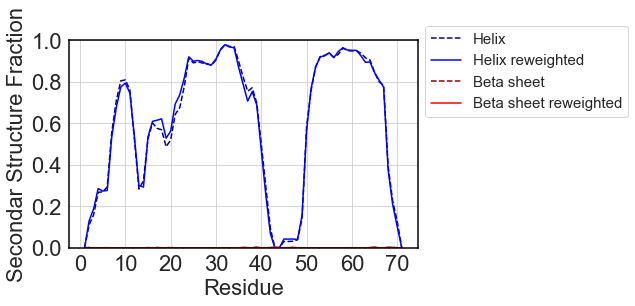

In [36]:
plt.clf()
plt.plot(prot_res_renum,Hprop,color='darkblue', label='Helix',linestyle='dashed')
plt.ylim(0,1.0)
plt.plot(prot_res_renum,reweight_Hprop,color='blue', label='Helix reweighted')
plt.plot(prot_res_renum,Eprop,color='darkred', label='Beta sheet',linestyle='dashed')
plt.plot(prot_res_renum,reweight_Eprop,color='red', label='Beta sheet reweighted')
plt.xlabel('Residue', size=22)
plt.ylabel('Secondar Structure Fraction', size=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor= (1.0, 0.85), fontsize=15)
plt.savefig('%s/SS.reweight.pdf'%outdir, bbox_inches='tight')

In [37]:
rg=calc_Rg(trj)
np.savetxt(outdir+"/Rg.dat",rg,fmt="%.3f")
print("CA Radius of Gyration All:%6.3lf"%np.average(rg),"+_%6.3lf"%block(rg)**.5)
np.savetxt(outdir+"/Rg.ave.dat",np.column_stack((np.average(rg),block(rg)**.5)),fmt="%.3f")

CA Radius of Gyration All: 1.421 +_ 0.013


In [38]:
def pmf1d(x,nbins,range=None, weights = None, return_bin_centers = True):
    count,edge = np.histogram(x,bins = nbins,range=range,weights = weights)
    if weights is None:
        p = count/len(x)
    else:
        p = count
    if return_bin_centers:
        return p,edge[:-1]+np.diff(edge)/2
    else:
        return p  
    

p1, bc1 = pmf1d(rg, nbins=50)
p2, bc2 = pmf1d(rg, nbins=50, weights=weights)

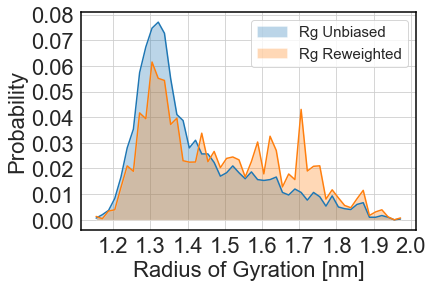

In [39]:
plt.plot(bc1,p1)
plt.plot(bc2,p2)
plt.fill_between(bc1,p1, alpha=0.3, label='Rg Unbiased')
plt.fill_between(bc2, p2, alpha=0.3, label='Rg Reweighted')
plt.legend(loc='upper right', fontsize=15)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Radius of Gyration [nm]',  fontsize=22)
plt.ylabel('Probability', fontsize=22)
plt.savefig('%s/Rg.probability.pdf'%outdir, bbox_inches='tight')

In [40]:
helixBB = md.load_pdb(helixpdb)
# ppIIBB = md.load_pdb(ppIIpdb)
# betaBB = md.load_pdb(betapdb)

trjBB = md.load(trajectory, top=pdb,stride=1)
trjBB = trjBB[1:]
BB=trjBB.topology.select("name CA")
HBB = helixBB.topology.select("name CA")
# PBB=ppIIBB.topology.select("name CA")
# BBB=betaBB.topology.select("name CA")


trjBB.restrict_atoms(BB)
helixBB.restrict_atoms(HBB)
# ppIIBB.restrict_atoms(PBB)
# betaBB.restrict_atoms(BBB)

trjBB.center_coordinates()
helixBB.center_coordinates()
# betaBB.center_coordinates()
# ppIIBB.center_coordinates()

Sa= calc_SA(trjBB,helixBB,0, 65)
# Sa_ppII = calc_SA(trjBB,ppIIBB,0, 65)
# Sa_beta = calc_SA(trjBB,betaBB,0, 65)

Sa_total=np.sum(Sa, axis=0)
Sa_ave=np.average(Sa,axis=1)
np.savetxt(outdir+"/Sa.dat",Sa,fmt="%.3f")
np.savetxt(outdir+"/Sa.total.dat",Sa_total,fmt="%.3f")

/Users/kaushikborthakur1211/opt/anaconda3/envs/New_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


In [41]:
rg_nmr = [1.742, 2.477, 2.141, 2.049, 2.403, 1.954, 1.482, 2.042, 2.487,
       2.059, 2.154, 1.997, 1.763, 1.774, 1.824, 1.687, 2.085, 1.933,
       2.309, 2.398, 2.154, 2.149, 1.853, 2.754, 2.282, 2.142, 2.091,
       2.284, 2.500, 1.689, 1.620, 1.906, 2.193, 2.649, 2.596, 2.316,
       2.312, 1.764, 2.423, 2.111, 1.858, 1.739, 1.833, 1.803, 1.500,
       2.300, 2.237, 2.731, 1.569, 1.921]


sa_nmr= [25.437, 17.776, 18.060, 18.863, 22.582, 20.718, 22.404, 17.322,
       20.287, 24.573, 19.850, 22.882, 19.979, 21.065, 19.789, 22.055,
       21.818, 23.304, 22.764, 19.602, 19.045, 23.159, 25.806, 16.820,
       18.496, 21.387, 20.129, 21.180, 19.583, 21.788, 21.902, 20.857,
       19.595, 22.899, 20.671, 24.207, 22.452, 21.754, 23.335, 22.418,
       19.665, 20.448, 17.662, 20.444, 21.512, 21.027, 19.664, 21.793,
       18.983, 23.190]

In [42]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 3.0


def plot_Rg_vs_Sa(a, b, T, y0, ymax, x0, xmax, scatter_x=None, scatter_y=None, weight=None, title="", filename="plot.pdf"):
    # Calculate free energy
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], density=True, weights=weight)
    free_energy = np.log(np.flipud(free_energy) + 0.000001)
    free_energy = -(0.001987 * T) * free_energy

    # Create and customize the plot
    fig = plt.figure(figsize=(10, 8))
    plt.scatter(scatter_x, scatter_y, marker='.', c='white', s=800, edgecolors='black', alpha=0.8)
    im = plt.imshow(free_energy, interpolation='gaussian', extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
                    cmap='jet', aspect='auto')
    plt.title(title, fontsize=30, pad=20)
    cbar_ticks = [0, 1, 2, 3]
    cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=15)
    cb.set_label("Free Energy (kcal/mol)", labelpad=35, fontsize=30, rotation=270)
    imaxes = plt.gca()
    plt.ylabel("Radius of Gyration [nm]", size=35, labelpad=15)
    plt.xlabel(r"S$\alpha$", size=35, labelpad=15)
    plt.xticks(fontsize=35)
    plt.yticks(fontsize=35)
    plt.axes(cb.ax)
    plt.clim(vmin=0.1, vmax=3.0)
    #plt.yticks(size='26')
    cb.ax.tick_params(labelsize=30)
    
    #create the path
    file_path = os.path.join(outdir, filename)
    
    
    plt.tight_layout()
    plt.savefig(file_path)
    plt.show()

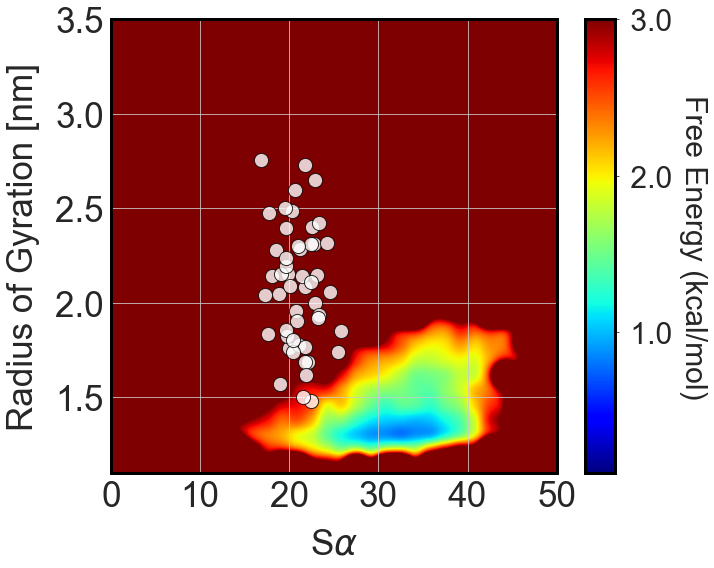

In [45]:
plot_Rg_vs_Sa(rg, Sa_total, 300, 1.1, 3.5, 0, 50, scatter_x=sa_nmr, scatter_y=rg_nmr, weight=None, title='', filename='unbiased.rg_vs_sa.pdf')

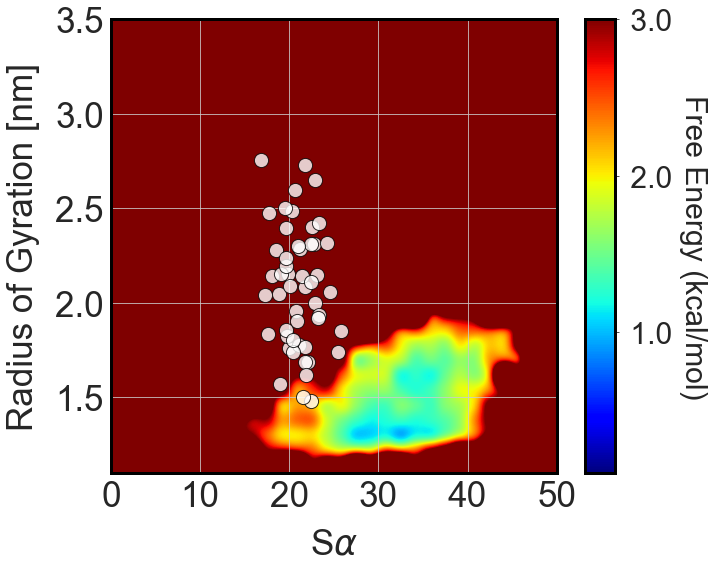

In [47]:

plot_Rg_vs_Sa(rg, Sa_total, 300, 1.1, 3.5, 0, 50, scatter_x=sa_nmr, scatter_y=rg_nmr, weight=weights, title='', filename='reweighted.rg_vs_sa.pdf')

In [48]:
contact_maps = []
distance_maps= []

contact_maps_reweight = []
distance_maps_reweight = []

for i in range(0,residues):
    contact_map = []
    distance_map = []

    contact_map_reweight = []
    distance_map_reweight = []
    for j in range(0,residues):
        if i == j:
            contacts = 0
            contacts_reweight = 0
            distance = 0
            distance_reweight =0
        else:
            dist = md.compute_contacts(trj,[[i,j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)

np.save(outdir+'distances.npy', distance)

In [49]:
contact_maps = []
distance_maps= []

contact_maps_reweight = []
distance_maps_reweight = []

for i in range(0,71):
    contact_map = []
    distance_map = []

    contact_map_reweight = []
    distance_map_reweight = []
    for j in range(0,71):
        if i == j:
            contacts = 0
            contacts_reweight = 0
            distance = 0
            distance_reweight =0
        else:
            dist = md.compute_contacts(trj,[[i,j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            distance_reweight= np.dot(array[:,0],weights)
            contact = np.where(array < 1.2, 1, 0)
            contacts = np.average(contact)
            contacts_reweight = np.dot(contact[:,0],weights)
        distance_map.append(distance)
        distance_map_reweight.append(distance_reweight)
        contact_map.append(contacts)
        contact_map_reweight.append(contacts_reweight)
    contact_maps.append(contact_map)
    contact_maps_reweight.append(contact_map_reweight)
    distance_maps.append(distance_map)
    distance_maps_reweight.append(distance_map_reweight)

final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(distance_maps).astype(float)

final_map_reweight = np.asarray(contact_maps_reweight).astype(float)
final_distance_reweight = np.asarray(distance_maps_reweight).astype(float)

In [50]:
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
len(sequence)

71

In [51]:
n=7
for i in range (0,len(sequence)):
  if (i % n !=0):
   sequence[i]=''

print(sequence)

[MET1, '', '', '', '', '', '', ASP8, '', '', '', '', '', '', PRO15, '', '', '', '', '', '', THR22, '', '', '', '', '', '', TYR29, '', '', '', '', '', '', LYS36, '', '', '', '', '', '', ASP43, '', '', '', '', '', '', HIS50, '', '', '', '', '', '', MET57, '', '', '', '', '', '', MET64, '', '', '', '', '', '', GLN71]


In [52]:
def plot_cmaps(map_data, residues, title=" ", filename = " " ):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    im = sns.heatmap(map_data, cmap = 'jet', ax = ax)
    ax.grid(which='both', alpha=0.5)


    plt.xticks(range(0,residues), sequence[0:residues], rotation=45, size=22)
    plt.yticks(range(0,residues),sequence[0:residues], rotation=45, size=22)

    cbar = im.collections[0].colorbar
    cbar.ax.tick_params(labelsize=30)
    cbar.set_label('Residue contact probability', labelpad=35, fontsize=30, rotation= 270)
    ax.set_title(title, size=30, pad=20 )
    ax.invert_yaxis()
    plt.tight_layout()
    
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(3)
    for _, spine in cbar.ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(3)
    
    filepath= os.path.join(outdir, filename)
    plt.savefig(filepath)

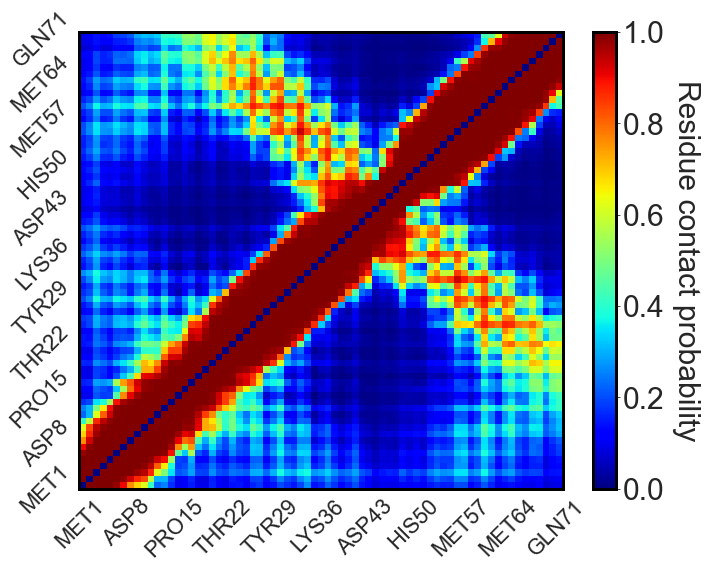

In [53]:
plot_cmaps(final_map, residues, title='', filename= "Unbiased_cmap.pdf")

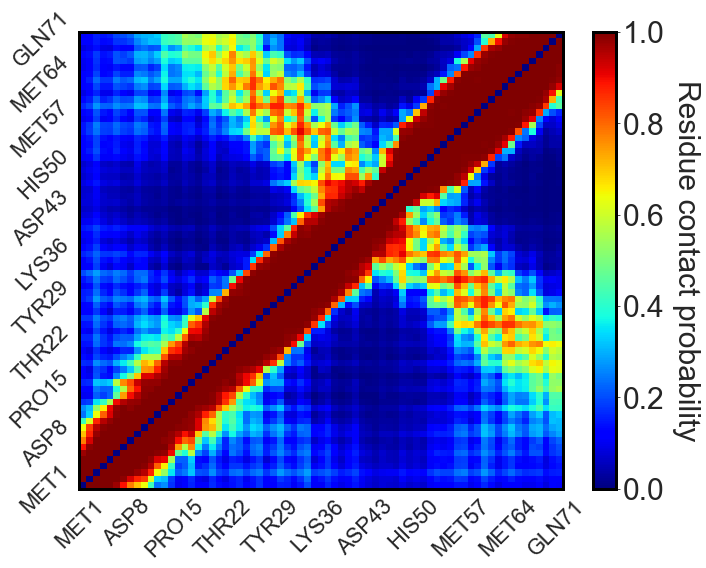

In [54]:
plot_cmaps(final_map_reweight, residues, title= '', filename='Reweighted_cmap.pdf')